In [1]:
# 0. Settings
!pip install laion-clap
!pip install torch
!pip install torchvision
!pip install torchaudio
import laion_clap
import glob
import json 
import torch
import numpy as np
import torchaudio
import tarfile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import glob
import tensorflow as tf
from tensorflow import keras
import pickle


In [2]:
keras.backend.clear_session()

# Define Classifier type

In [3]:
class_index_dict_path = 'label/synthsc.json'
column_name = 'Instrument' # 'genre', 'artist'

# Load Dataset

In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
        print(type(values))
    return values

In [61]:
clap_audio_embeds = load_pickle('data/clap_audio_embeds.pkl')
train_audio_embeds = load_pickle('data/strain_audio_embeds.pkl')
train_ground_truth_idx = load_pickle('data/strain_ground_truth_idx.pkl')
test_audio_embeds = load_pickle('data/stest_audio_embeds.pkl')
test_ground_truth_idx = load_pickle('data/stest_ground_truth_idx.pkl')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


In [6]:
train_ground_truth = np.array(train_ground_truth_idx)
test_ground_truth = np.array(test_ground_truth_idx)
print(train_ground_truth.shape,test_ground_truth.shape)

(288,) (31,)


In [7]:
print(train_audio_embeds.shape,train_ground_truth.shape)
print(test_audio_embeds.shape,test_ground_truth.shape)
print(type(train_audio_embeds),type(train_ground_truth))

(288, 512) (288,)
(31, 512) (31,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Modeling (1) - Input : train_audio_embeds

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
np.random.seed(42)
tf.random.set_seed(42)

input_shape = train_audio_embeds.shape
num_classes = 3

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model
history = model.fit(train_audio_embeds, train_ground_truth, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stop]) #32

import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_28 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 512)


Epoch 1/50
5/5 [==============================] - 1s 38ms/step - loss: 1.3724 - accuracy: 0.4170 - val_loss: 1.1163 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.2933 - accuracy: 0.4903 - val_loss: 1.1060 - val_accuracy: 0.2414
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1320 - accuracy: 0.5328 - val_loss: 1.0959 - val_accuracy: 0.2759
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1776 - accuracy: 0.5019 - val_loss: 1.0877 - val_accuracy: 0.2759
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1580 - accuracy: 0.5483 - val_loss: 1.0769 - val_accuracy: 0.2759


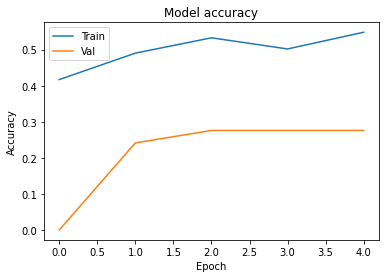

In [56]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
np.random.seed(42)
tf.random.set_seed(42)

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=train_audio_embeds.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model
history = model.fit(train_audio_embeds, train_ground_truth, validation_split=0.1, epochs=50, batch_size=64, callbacks=[early_stop]) #32

import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [57]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_audio_embeds, test_ground_truth)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


1/1 [==============================] - 0s 17ms/step - loss: 1.0643 - accuracy: 0.4839
Test loss: 1.0643426179885864
Test accuracy: 0.4838709533214569


<AxesSubplot:>

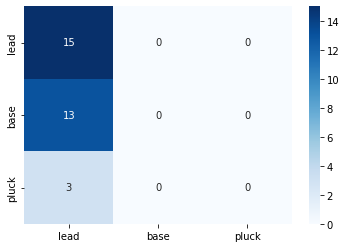

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test data
test_predictions = model.predict(test_audio_embeds).argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(test_ground_truth, test_predictions)

# Plot confusion matrix

class_names = ['lead', 'base', 'pluck']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)